# Template strategy tester
Get the data from file then conintue with the analysis.

In [1]:
import plotly.io as pio
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Load the CSV file
file_path = '/Users/gabrielefabietti/projects/fetch_data/data/SOLUSDT_perp_1h_2023-01-01_to_2023-01-15.csv'  # Adjust this path accordingly
data = pd.read_csv(file_path)

# Convert the timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Display the first few rows to inspect the data
print(data.head())
data.info()

                       open    high    low   close     volume      turnover
timestamp                                                                  
2022-12-31 23:00:00   9.940   9.990  9.885   9.965   880719.6  8.764036e+06
2023-01-01 00:00:00   9.965  10.020  9.920   9.980  1018149.5  1.015674e+07
2023-01-01 01:00:00   9.980  10.055  9.970  10.020   627647.8  6.289809e+06
2023-01-01 02:00:00  10.020  10.070  9.980  10.000   603113.7  6.046047e+06
2023-01-01 03:00:00  10.000  10.000  9.895   9.950   847659.5  8.428801e+06
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2022-12-31 23:00:00 to 2023-01-14 23:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      350 non-null    float64
 1   high      350 non-null    float64
 2   low       350 non-null    float64
 3   close     350 non-null    float64
 4   volume    350 non-null    float64
 5   turnover  350 non-null    float64
dtypes: float64

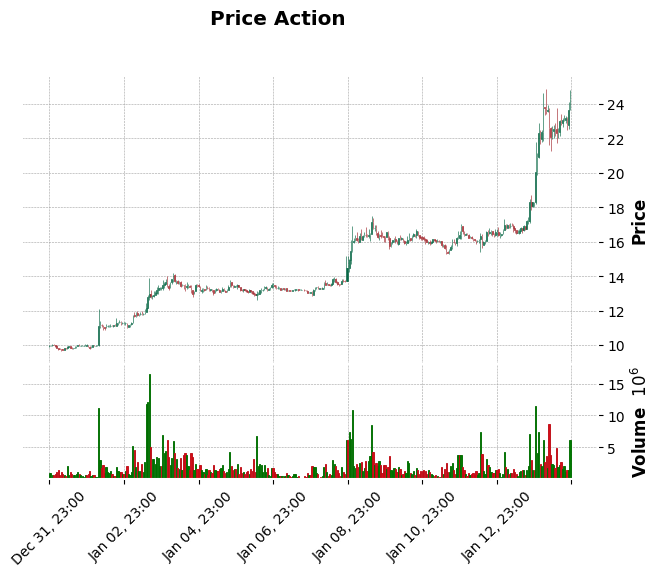

In [3]:
# Plot the candlestick chart
mpf.plot(data, type='candle', style='charles', title='Price Action', ylabel='Price', volume=True)

In [4]:
# add needed indicators

# Calculate the 24-period (24-hour) moving average of the volume
data['volume_MA'] = data['volume'].rolling(window=5).mean()
# Calculate the 100-period (100-hour) moving average of the closing prices
data['close_MA_100'] = data['close'].rolling(window=100).mean()

In [5]:
# Initialize a list to store setups
setups = []

da = 3

# Loop through the data to identify setups
for i in range(100, len(data) - da):  # Start from 100 to ensure enough data for the 100-period MA
    # Check if the 100-period MA is going up or down
    if data['close_MA_100'].iloc[i] > data['close_MA_100'].iloc[i-1]:
        trend = 'up'
    else:
        trend = 'down'
    
    # Check the volume condition
    if trend == 'up' and data['close'].iloc[i] < data['open'].iloc[i] and data['volume'].iloc[i] >= 2 * data['volume_MA'].iloc[i]:
        # Uptrend setup: down candle with volume >= 2 * 24-period MA volume
        price_diff_percentage = ((data['close'].iloc[i+da] - data['close'].iloc[i]) / data['close'].iloc[i]) * 100
        setups.append((data.index[i], 'long', price_diff_percentage))
    elif trend == 'down' and data['close'].iloc[i] > data['open'].iloc[i] and data['volume'].iloc[i] >= 2 * data['volume_MA'].iloc[i]:
        # Downtrend setup: up candle with volume >= 2 * 24-period MA volume
        price_diff_percentage = ((data['close'].iloc[i] - data['close'].iloc[i+da]) / data['close'].iloc[i]) * 100
        setups.append((data.index[i], 'short', price_diff_percentage))

# Convert setups to DataFrame
setups_df = pd.DataFrame(setups, columns=['timestamp', 'Setup', 'Price_Diff_Percentage'])


# Ensure 'Time' column in setups_df is a datetime
setups_df['timestamp'] = pd.to_datetime(setups_df['timestamp'])
# setups_df.set_index('timestamp', inplace=True)

In [6]:
print(setups_df)
mean_x_trade = setups_df['Price_Diff_Percentage'].mean()
print("Mean return per trade: ", round(mean_x_trade, 4), "%")

total_setups = len(setups_df)
positive_outcomes = (setups_df['Price_Diff_Percentage'] > 0).sum()
# Calculate the percentage of positive outcomes
percentage_positive = (positive_outcomes / total_setups) * 100

print(f"Percentage of positive outcomes: {percentage_positive:.2f}%")

long_setups = (setups_df['Setup'] == 'long').sum()
percentage_longs = long_setups / total_setups * 100

print(f"Percentage of long setups: {percentage_longs:.2f}%")

            timestamp  Setup  Price_Diff_Percentage
0 2023-01-08 08:00:00  short               0.698786
1 2023-01-11 12:00:00   long              -2.531646
Mean return per trade:  -0.9164 %
Percentage of positive outcomes: 50.00%
Percentage of long setups: 50.00%


            timestamp  Setup  Price_Diff_Percentage  Capital_After_Trade
0 2023-01-08 08:00:00  short               0.698786        100698.786318
1 2023-01-11 12:00:00   long              -2.531646         98149.449956
Final capital: 98149.45


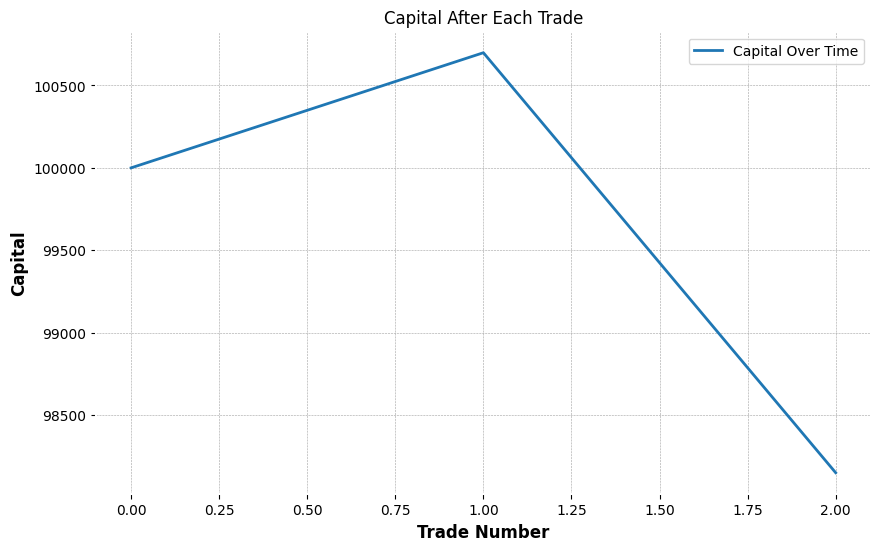

In [7]:
# Initialize capital
initial_capital = 100000
capital = initial_capital

# Initialize a list to track capital over time
capital_over_time = [capital]

# Simulate the strategy
for i, row in setups_df.iterrows():
    # Calculate the change in capital based on the price difference percentage
    capital_change = capital * (row['Price_Diff_Percentage']/100)
    capital += capital_change
    capital_over_time.append(capital)

# Add the capital over time to the setups_df for tracking
setups_df['Capital_After_Trade'] = capital_over_time[1:]  # Skip the initial capital entry

# Display the first few rows of the updated DataFrame
print(setups_df.head())

# Print final capital
print(f"Final capital: {capital:.2f}")

# Plot the capital over time
plt.figure(figsize=(10, 6))
plt.plot(capital_over_time, label='Capital Over Time')
plt.xlabel('Trade Number')
plt.ylabel('Capital')
plt.title('Capital After Each Trade')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Set the start and end date for the 5-day window
start_date = '2023-10-20'
end_date = '2023-11-10'

# Filter the data for this date range
filtered_data = data.loc[start_date:end_date]

# Filter setups to include only those within the date range
filtered_setups = setups_df[(setups_df['timestamp'] >= pd.to_datetime(start_date)) & (setups_df['timestamp'] <= pd.to_datetime(end_date))]

# Display the filtered data and setups to verify
print(filtered_data.head())
print(filtered_setups.head())

print("N. of setups in this period: ",len(filtered_setups))

Empty DataFrame
Columns: [open, high, low, close, volume, turnover, volume_MA, close_MA_100]
Index: []
Empty DataFrame
Columns: [timestamp, Setup, Price_Diff_Percentage, Capital_After_Trade]
Index: []
N. of setups in this period:  0


In [9]:
# Create the basic candlestick chart
fig = go.Figure()

# Add candlestick chart
fig.add_trace(go.Candlestick(
    x=filtered_data.index,
    open=filtered_data['open'],
    high=filtered_data['high'],
    low=filtered_data['low'],
    close=filtered_data['close'],
    name='Candlesticks'
))

# Add volume bars with lighter color and smaller scale
fig.add_trace(go.Bar(
    x=filtered_data.index,
    y=filtered_data['volume'] / 1000,  # Scale down volume
    name='Volume',
    marker_color='lightblue',
    yaxis='y2'  # Use secondary y-axis
))

# Add 100-period moving average
fig.add_trace(go.Scatter(
    x=filtered_data.index,
    y=filtered_data['close_MA_100'],
    mode='lines',
    name='100-period MA',
    line=dict(color='orange', width=2)
))

# Add 100-period moving average for volume
fig.add_trace(go.Scatter(
    x=filtered_data.index,
    y=filtered_data['volume_MA'] / 1000,  # Scale down volume MA
    mode='lines',
    name='Volume MA',
    line=dict(color='lightgrey', width=2),
    yaxis='y2'  # Use secondary y-axis
))

# Add setups annotations using small dots
for i, row in filtered_setups.iterrows():
    if row['Setup'] == 'short':
        fig.add_trace(go.Scatter(
            x=[row['timestamp']],
            y=[filtered_data.loc[row['timestamp'], 'high'] + filtered_data.loc[row['timestamp'], 'high'] * 0.003],  # Small dot above the high of the candle
            mode='markers',
            marker=dict(color='red', size=10),
            name='Short Setup'
        ))
    elif row['Setup'] == 'long':
        fig.add_trace(go.Scatter(
            x=[row['timestamp']],
            y=[filtered_data.loc[row['timestamp'], 'low'] - filtered_data.loc[row['timestamp'], 'low'] * 0.003],  # Small dot below the low of the candle
            mode='markers',
            marker=dict(color='green', size=10),
            name='Long Setup'
        ))

# Update layout to add secondary y-axis for volume and adjust the size and colors
fig.update_layout(
    height=800,  # Adjust height for a taller graph
    plot_bgcolor='white',  # Set background color to white
    yaxis=dict(
        title='Price',
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis2=dict(
        title='Volume',
        overlaying='y',
        side='right',
        showgrid=False,
        position=1.0,  # Move the secondary y-axis to the right
        range=[0, max(filtered_data['volume'] / 1000) * 5]  # Adjust the range for better visibility
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    title='Perpetual Futures'
)

# Show the plot
fig.show()

ValueError: max() iterable argument is empty